# This is a pipeline to visualize and analyze the results of CellProfiler on inmunohistochemistry experiments done for PH3

In [89]:
# Import stuff
%load_ext autoreload
%autoreload 2
import os
from utils import data_reader
from utils import plot_utils
from utils import generic_functions as gf
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
#from ggplot import *
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import random

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
# Select the path where the data is (the output of CellProfiler)
CPoutput_path = '/mnt/c/Users/herny/Desktop/SWC/Data/Microscopy_Data/Plasticity/PH3_inmuno/Cell_profiler_output/'


In [91]:
# Import the data
df = data_reader.PH3_data_reader(CPoutput_path)

In [92]:
# Rename channels
#df = df.rename(columns={"Children_FinalDots_C2_Count": "drd2_count",
#                        "Children_FinalDots_C3_Count": "drd1_count"})

In [93]:
df

AnimalID ExperimentalCondition Slide Slice Side    AP ROI  ObjectNumber  \
0        PH301              A2A-Ai14     1     0    L  Tail  10             1   
1        PH301              A2A-Ai14     1     0    L  Tail  10             2   
2        PH301              A2A-Ai14     1     0    L  Tail  10             3   
3        PH301              A2A-Ai14     1     0    L  Tail  10             4   
4        PH301              A2A-Ai14     1     0    L  Tail  10             5   
...        ...                   ...   ...   ...  ...   ...  ..           ...   
51948    PH301              A2A-Ai14     1     5    R  Tail   9           353   
51949    PH301              A2A-Ai14     1     5    R  Tail   9           354   
51950    PH301              A2A-Ai14     1     5    R  Tail   9           355   
51951    PH301              A2A-Ai14     1     5    R  Tail   9           356   
51952    PH301              A2A-Ai14     1     5    R  Tail   9           357   

       MedianI_C2  MedianI_C3  MedianI_C4  MeanI_C2  MeanI_C3  MeanI_C4  \
0        0.360784    0.752941    0.407843  0.366423  0.741471  0.410246   
1        0.494118    0.376471    0.376471  0.496756  0.395708  0.377823   
2        0.196078    0.227451    0.376471  0.200450  0.226149  0.383472   
3        0.247059    0.364706    0.392157  0.251851  0.372683  0.402086   
4        0.129412    0.066667    0.223529  0.131755  0.067565  0.229131   
...           ...         ...         ...       ...       ...       ...   
51948    0.517647    0.317647    0.486275  0.513787  0.320264  0.490248   
51949    0.666667    0.282353    0.639216  0.668485  0.285937  0.643624   
51950    0.505882    0.309804    0.623529  0.514860  0.313736  0.626281   
51951    0.478431    0.388235    0.592157  0.484297  0.386178  0.596825   
51952    0.482353    0.552941    0.580392  0.482563  0.547936  0.578320   

          Center_X     Center_Y  \
0       275.346444    30.894319   
1       330.336699    29.484099   
2      1438.401119    31.073694   
3       107.715245    37.061786   
4      1787.288373    51.762645   
...            ...          ...   
51948   540.569994  2262.539862   
51949  1505.460335  2257.505028   
51950  1779.423237  2261.188278   
51951  1964.828010  2257.667690   
51952   853.659860  2258.841736   

                                       PathName_Channel1  
0      C:\Users\herny\Desktop\SWC\Data\Microscopy_Dat...  
1      C:\Users\herny\Desktop\SWC\Data\Microscopy_Dat...  
2      C:\Users\herny\Desktop\SWC\Data\Microscopy_Dat...  
3      C:\Users\herny\Desktop\SWC\Data\Microscopy_Dat...  
4      C:\Users\herny\Desktop\SWC\Data\Microscopy_Dat...  
...                                                  ...  
51948  C:\Users\herny\Desktop\SWC\Data\Microscopy_Dat...  
51949  C:\Users\herny\Desktop\SWC\Data\Microscopy_Dat...  
51950  C:\Users\herny\Desktop\SWC\Data\Microscopy_Dat...  
51951  C:\Users\herny\Desktop\SWC\Data\Microscopy_Dat...  
51952  C:\Users\herny\Desktop\SWC\Data\Microscopy_Dat...  

[51953 rows x 17 columns]

***
### Sanity checks on the data
***

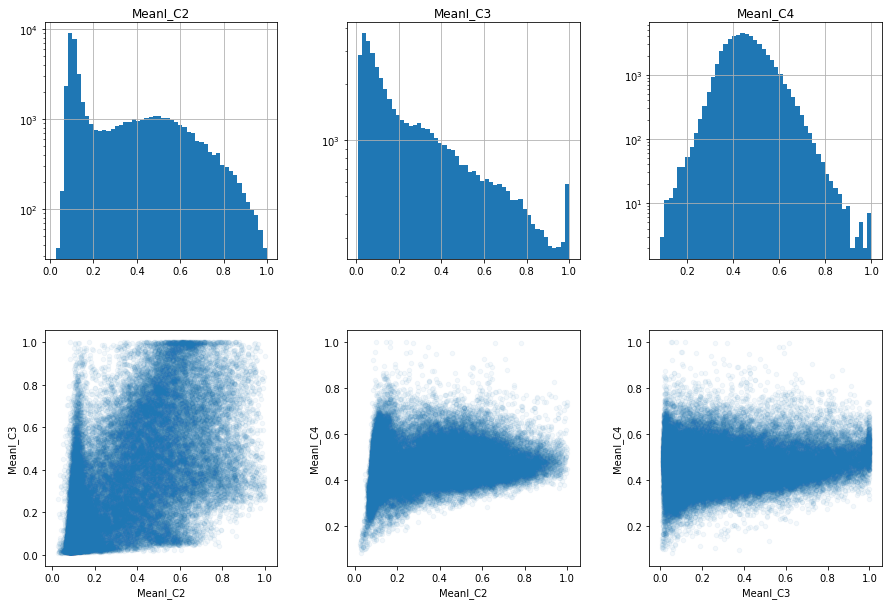

In [94]:
# plot histograms of counts for all the cells
channels = ["MedianI_C2", "MedianI_C3", "MedianI_C4"]
channels = ["MeanI_C2", "MeanI_C3", "MeanI_C4"]
%matplotlib inline
fig, axs = plt.subplots(2, ncols=3, sharey=False, figsize=(15,10))
axs = axs.ravel()
axArr = [axs[0], axs[1], axs[2]]
i = 0
for axis in axArr:
    df.hist(channels[i], ax = axis, bins=50)
    #sns.distplot(df[channels[i]], ax = axis)
    axis.set_yscale("log")
    #axis.set_ylim(0,1000)
    axis.set_title(channels[i])
    i+=1
df.plot.scatter(channels[0],channels[1], ax = axs[3], alpha = 0.05)
df.plot.scatter(channels[0],channels[2], ax = axs[4], alpha = 0.05)
df.plot.scatter(channels[1],channels[2], ax = axs[5], alpha = 0.05)

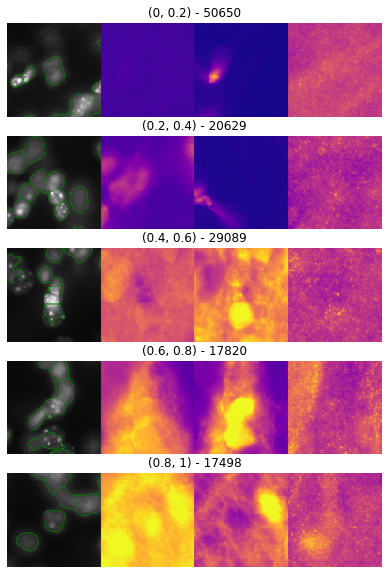

In [95]:
# find which cells are SPNs. Explore the threshold
sc = 'MeanI_C2'
# plot randomly sets of cells within certain values of channel 2, which is DARPP-32
thresholds = ((0, .2), (.2, .4), (.4, .6), (.6, .8), (.8, 1))
#create an empty list
indexes = []
# get the indexes of these cohorts
for tr in thresholds:
    shuffledIdx = df[np.logical_and(df[sc]>=tr[0], df[sc]<tr[1])].index.values
    # shuffle them
    np.random.shuffle(shuffledIdx)
    # append first
    indexes.append(shuffledIdx[0])
fig = plt.subplots(sharey=False, figsize=(15,np.ceil(2*len(thresholds))))
for counter, i in enumerate(indexes):
    CellImage = plot_utils.plotPH3Cell(df.iloc[i], CPoutput_path, window=130, lut='plasma')
    plt.subplot(len(thresholds), 1, counter+1)
    plt.grid(False)
    plt.axis('off')
    plt.title(str(thresholds[counter]) + " - " + str(i))
    plt.imshow(CellImage)

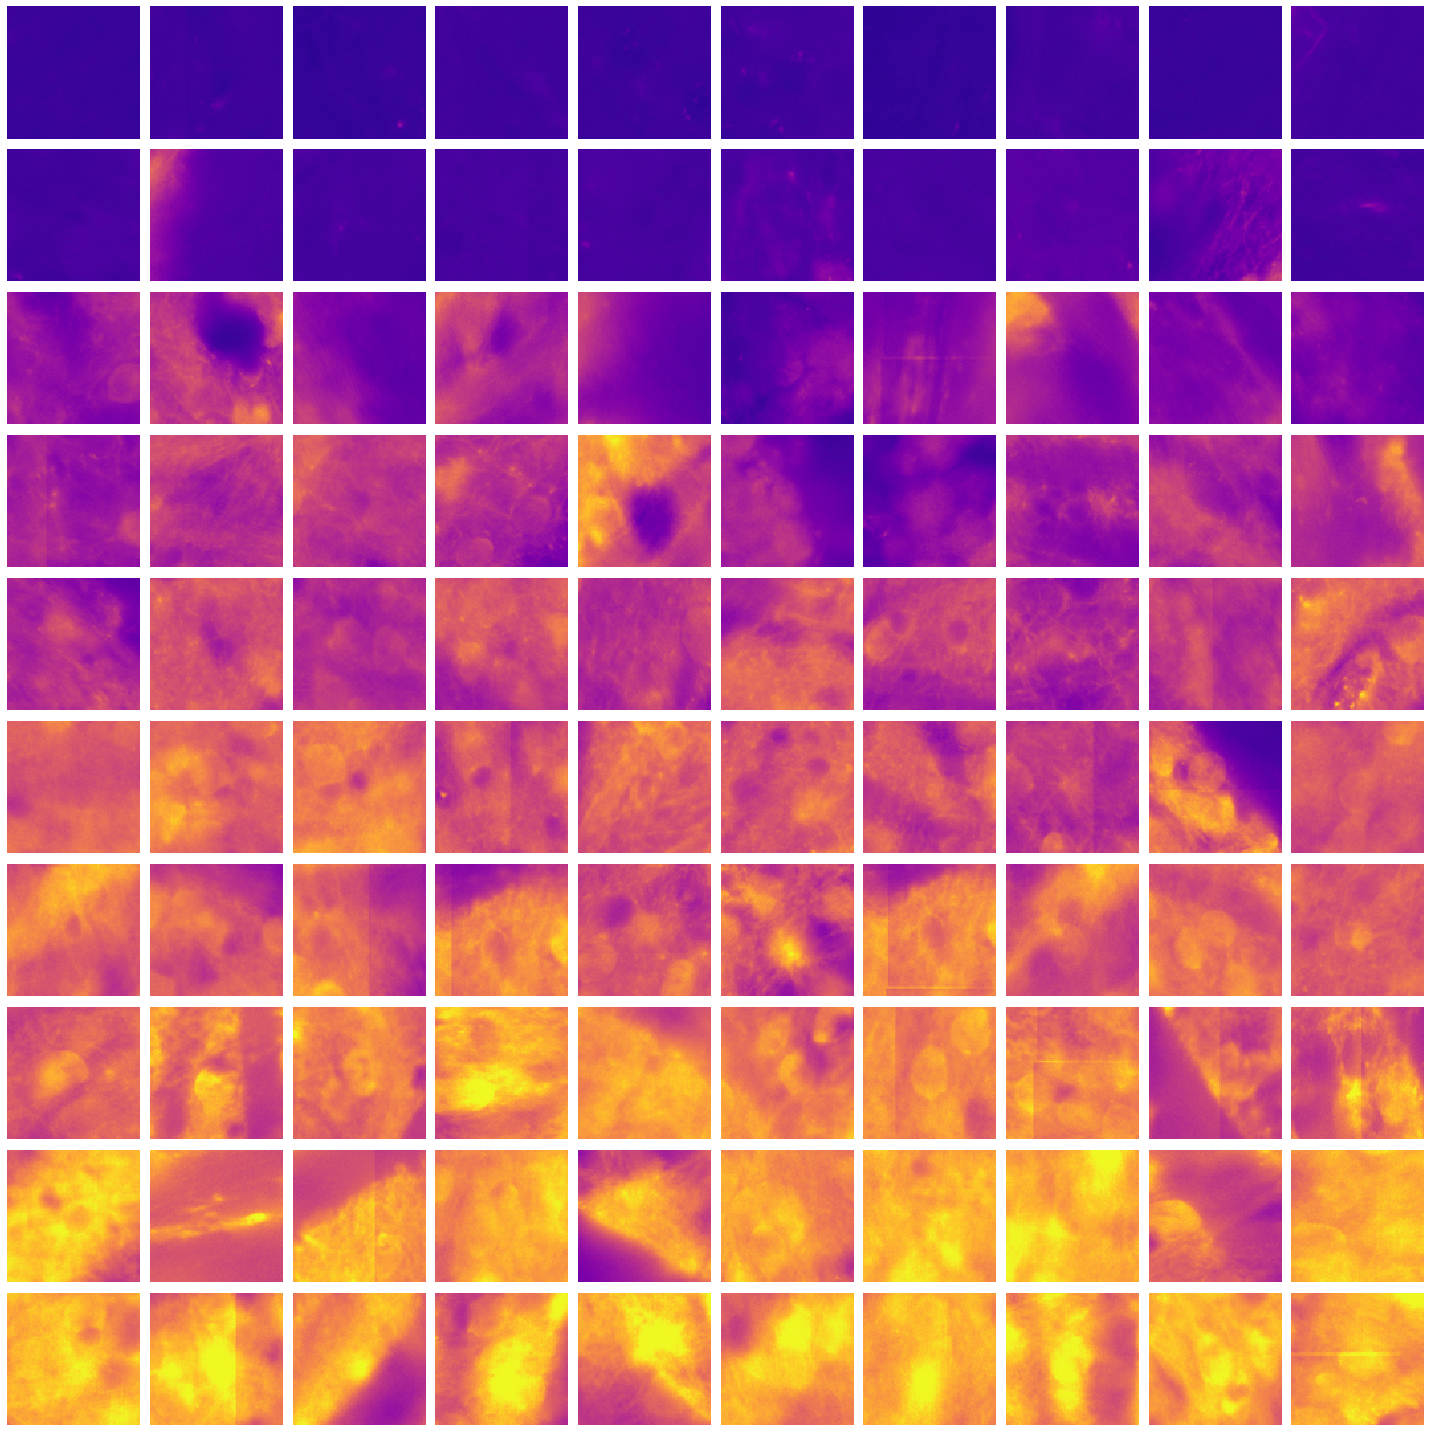

In [99]:
# plot just one channel
channel = 2
ncells = 10
sc = 'MeanI_C' + str(channel)
# plot randomly sets of cells within certain values of channel 2, which is DARPP-32
thresholds = ((0, .1), (.1, .2), (.2, .3), (.3, .4), (.4, .5),
              (.5, .6), (.6, .7), (.7, .8), (.8, .9), (.9, 1))
# get indexes to plot
indexes = gf.get_indexes_by_thr(df, sc, thresholds, ncells)
# plot
fig, axs = plt.subplots(len(thresholds), ncells, sharey=False, figsize=(np.ceil(2*ncells), np.ceil(2*len(thresholds))))
fig = plot_utils.plot_channel_of_indexes(fig, axs, indexes, df, channel, window=130, lut='plasma')
fig.show()

In [105]:
# select a criteria for what is an SPN
SPN_thr = .6
dfsel = df[df.MeanI_C2 >= SPN_thr]
dfsel.shape

(7405, 17)

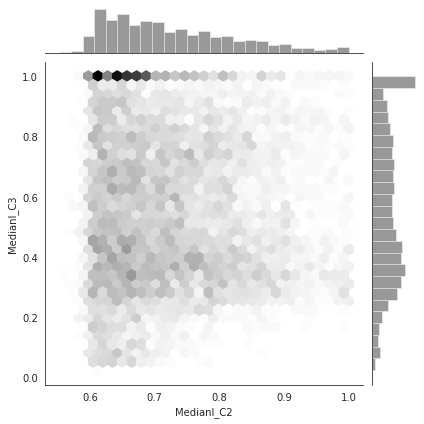

In [106]:
# plot the distribution to select a threshold for which ones are d1 and which ones d2
%matplotlib inline
pal = sns.cubehelix_palette(light=1, as_cmap=True)
with sns.axes_style("white"):
    sns.jointplot(x='MedianI_C2',
                  y='MedianI_C3',
                  data=dfsel,
                  kind="hex",
                  #bins='log',
                  # cmap=pal,
                  joint_kws=dict(gridsize=30),
                  color='k',
                  ratio=6,
                  marginal_kws=dict(bins=25, rug=False))


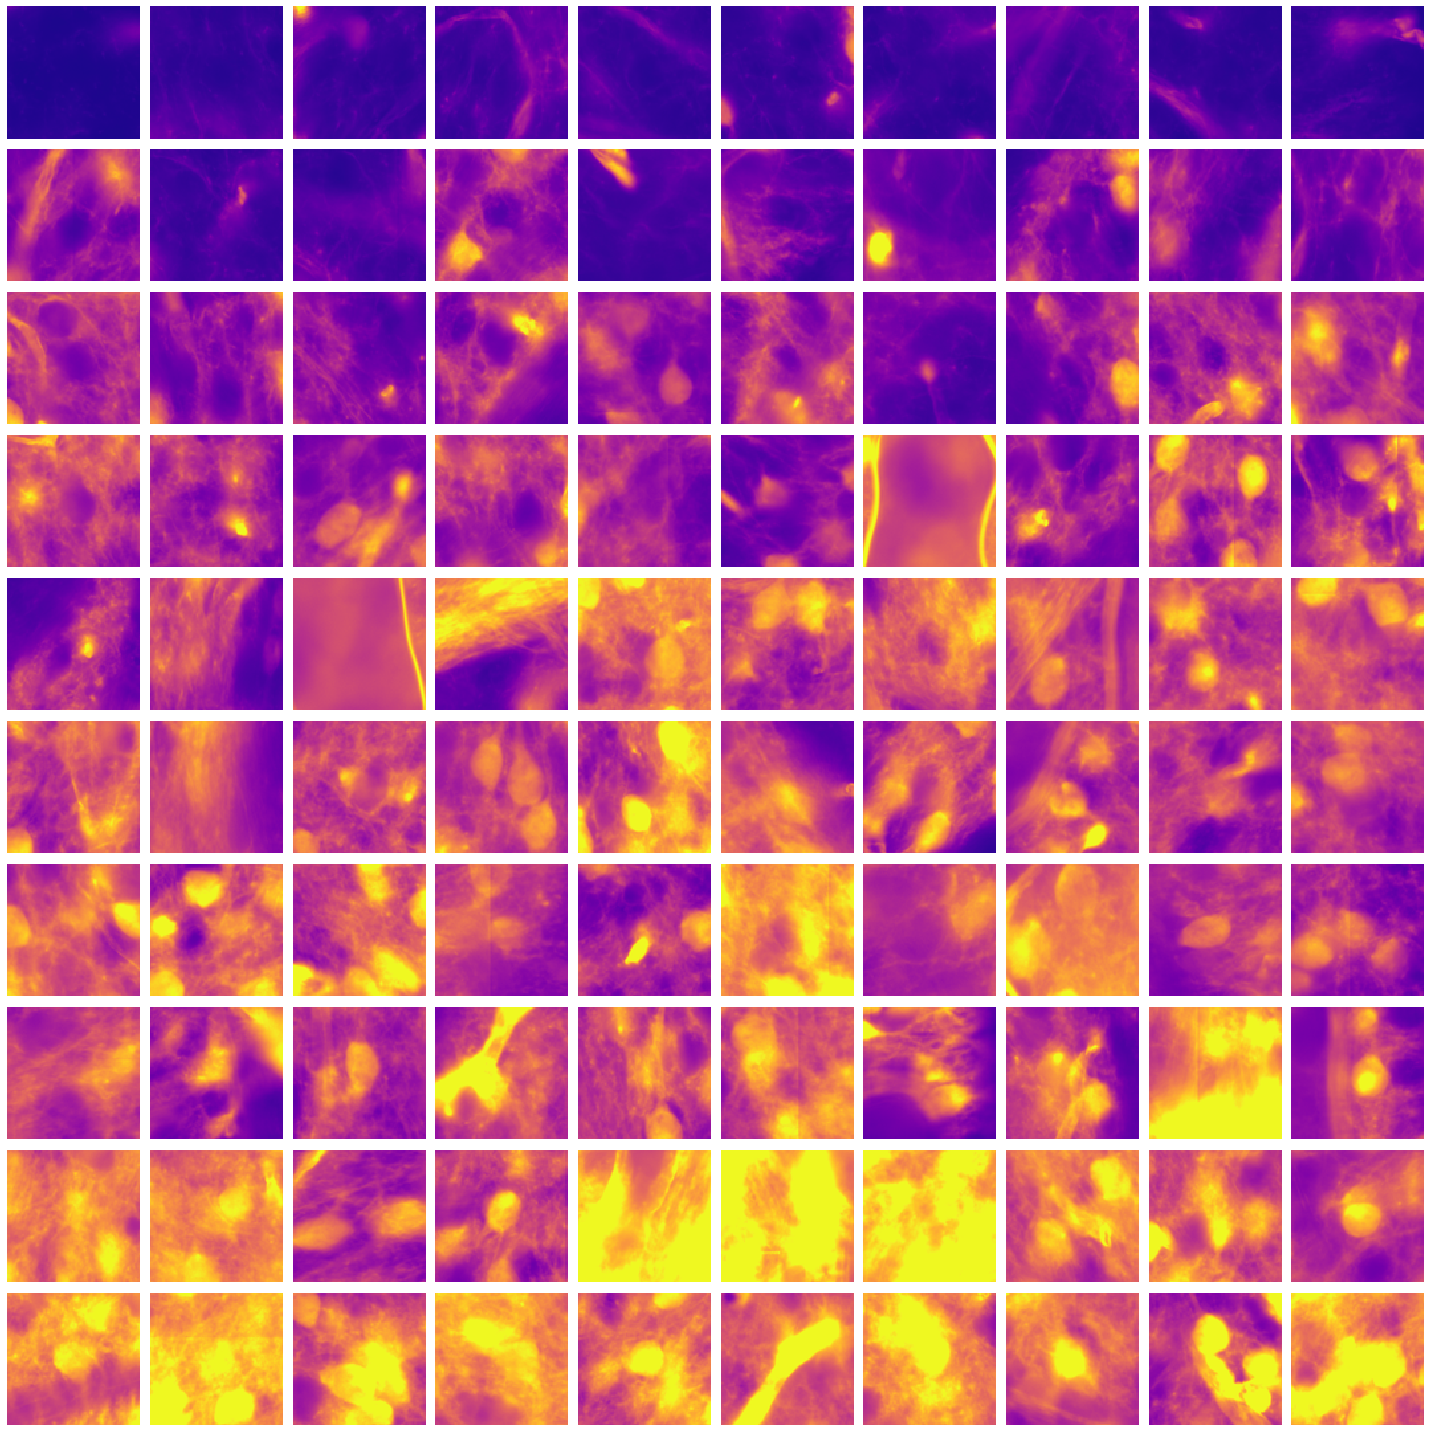

In [107]:
# see the tdtomato cells
channel = 3
ncells = 10
sc = 'MeanI_C' + str(channel)
# plot randomly sets of cells within certain values of channel 2, which is DARPP-32
thresholds = ((0, .1), (.1, .2), (.2, .3), (.3, .4), (.4, .5),
              (.5, .6), (.6, .7), (.7, .8), (.8, .9), (.9, 1))
# get indexes to plot
indexes = gf.get_indexes_by_thr(dfsel, sc, thresholds, ncells)
# plot
fig, axs = plt.subplots(len(thresholds), ncells, sharey=False, figsize=(np.ceil(2*ncells), np.ceil(2*len(thresholds))))
fig = plot_utils.plot_channel_of_indexes(fig, axs, indexes, dfsel, channel, window=130, lut='plasma')
fig.show()

In [110]:
tdtomato_thr = .54
100 * sum(dfsel.MeanI_C3 > tdtomato_thr) / dfsel.shape[0]

50.303848750844026

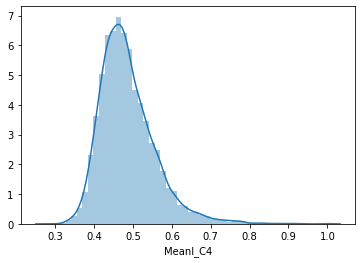

In [111]:
# plot the distribution to select a threshold for which ones are PH3+
ax = sns.distplot(dfsel.MeanI_C4)
#ax.set_yscale('log')

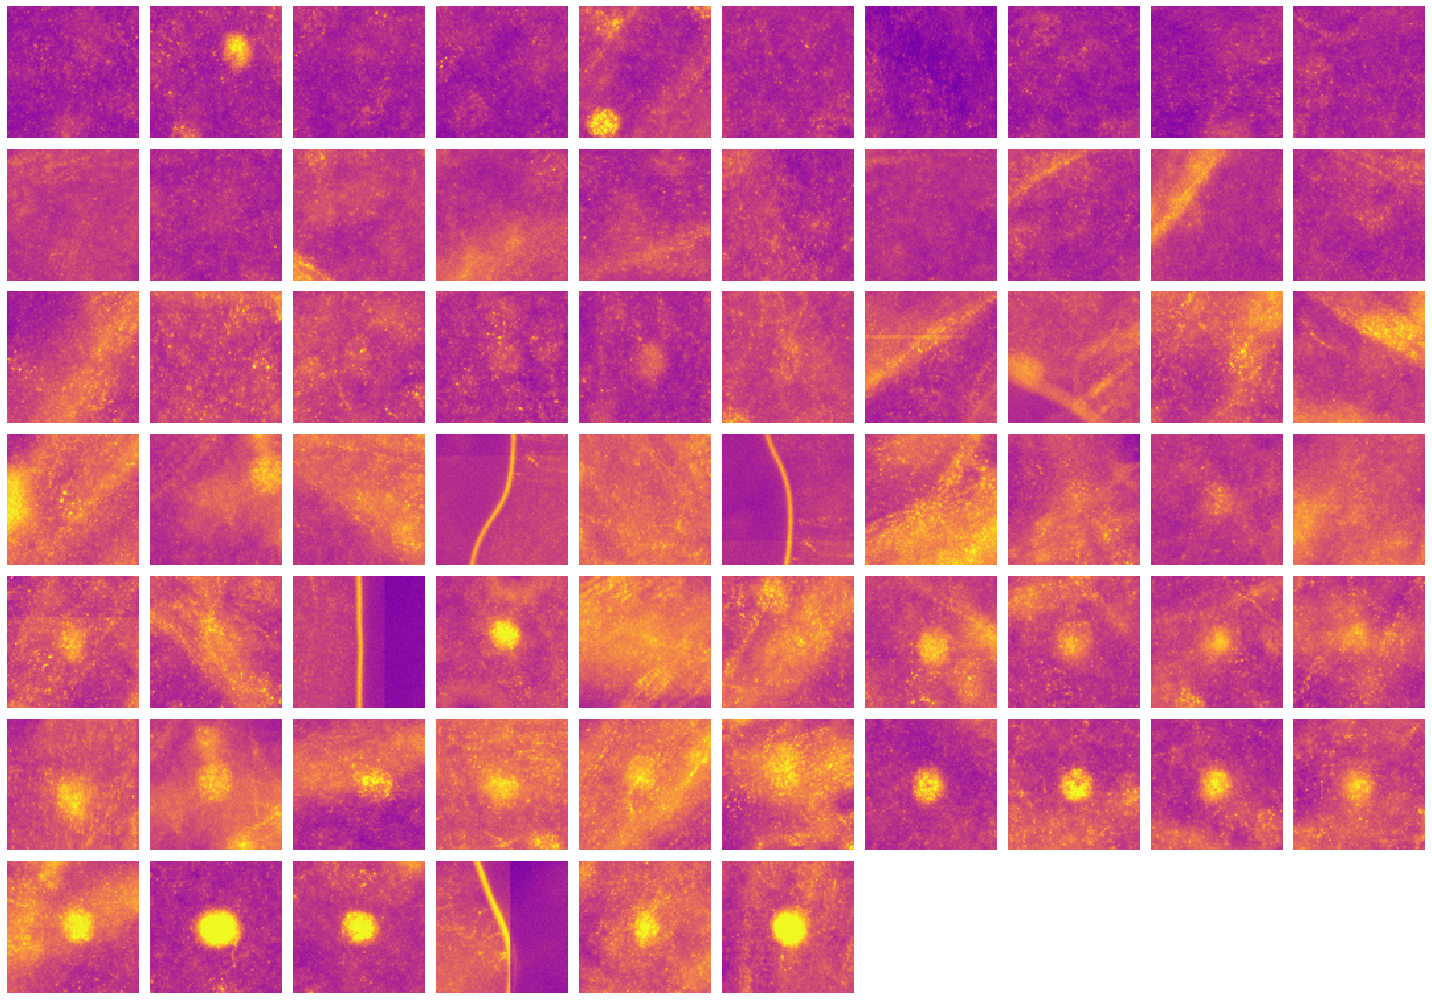

In [112]:
# find which cells are PH3 positive
channel = 4
ncells = 10
sc = 'MeanI_C' + str(channel)
# plot randomly sets of cells within certain values of channel 2, which is DARPP-32
thresholds = ((.3, .4), (.4, .5),
              (.5, .6), (.6, .7), (.7, .8), (.8, .9), (.9, 1))
# get indexes to plot
indexes = gf.get_indexes_by_thr(dfsel, sc, thresholds, ncells)
# plot
fig, axs = plt.subplots(len(thresholds), ncells, sharey=False, figsize=(np.ceil(2*ncells), np.ceil(2*len(thresholds))))
fig = plot_utils.plot_channel_of_indexes(fig, axs, indexes, dfsel, channel, window=130, lut='plasma')
fig.show()

In [117]:
# total number of PH3 cells
ph3_thr = .8
dfselsel = dfsel[dfsel.MeanI_C4 >= ph3_thr]
dfselsel.shape[0]

19

In [118]:
# percent of positive cells in the selected dataset (SPNs)
100 * dfselsel.shape[0] / dfsel.shape[0]

0.2565833896016205

In [119]:
# percent of what would be the total PH3+ cells
100 * dfselsel.shape[0] / sum(df.MedianI_C4 >= ph3_thr)

15.702479338842975

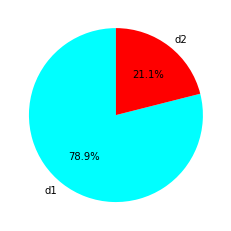

In [120]:
nd2 = sum(dfselsel.MedianI_C3 >= tdtomato_thr)
nd1 = sum(dfselsel.MedianI_C3 < tdtomato_thr)
ax = plt.pie([nd1, nd2], labels=['d1', 'd2'], colors=['cyan', 'red'],
             autopct='%1.1f%%', shadow=False, startangle=90)

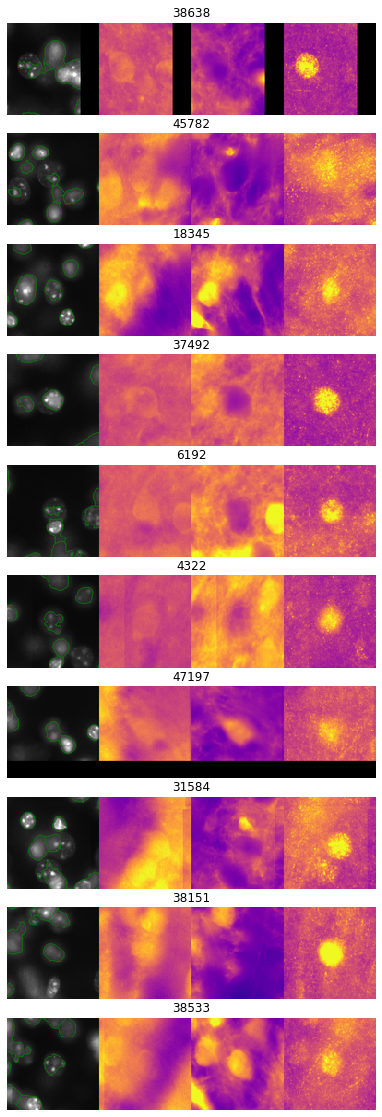

In [25]:
# plot some of the cells
ncells = 10
shuffledIdx = dfselsel.index.values
# shuffle them
np.random.shuffle(shuffledIdx)
shuffledIdx = shuffledIdx[0:ncells]
fig = plt.subplots(sharey=False, figsize=(15,np.ceil(2*ncells)))
for counter, i in enumerate(shuffledIdx):
    CellImage = plot_utils.plotPH3Cell(dfselsel.loc[i], CPoutput_path, window=130, lut='plasma')
    plt.subplot(ncells, 1, counter+1)
    plt.grid(False)
    plt.axis('off')
    plt.title(str(i))
    plt.imshow(CellImage)